In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
train_data_file = '../data/exercise_files/train.h5ad'
test_data_file = '../data/exercise_files/test.h5ad'

In [3]:
adata_train = sc.read_h5ad(train_data_file)
adata_test = sc.read_h5ad(test_data_file)

In [4]:
print(adata_train.shape)
print(adata_test.shape)

(7000, 27037)
(7000, 27037)


In [5]:
adata_train.obs.head()

,cell_type,original_cell_type
run_4_PC-12D.ACTTCCGTTAGTAACGGTC-0,Placodal ectoderm,Placodal area
run_21_PB-02H_S112.TGCGTAGTTCGAGCTGCCA-10,Hindgut,Midgut/Hindgut epithelial cells
run_14_PX-06G_S143.GCTTCTGGTTTCTTAATAA-2,Dorsal spinal cord progenitors,Spinal cord dorsal progenitors
run_16_PC-10C_S267.AAAGCTGATTTTACGATGAA-4,Hindgut,Gut
run_4_PE-02C.ACGCTTATATTGACGCTCCG-0,Midbrain/Hindbrain boundary,Posterior roof plate


In [6]:
adata_train.var_names

Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000102343',
       'ENSMUSG00000025900', 'ENSMUSG00000025902', 'ENSMUSG00000104328',
       'ENSMUSG00000033845', 'ENSMUSG00000025903', 'ENSMUSG00000104217',
       'ENSMUSG00000033813',
       ...
       'ENSMUSG00000064354', 'ENSMUSG00000064356', 'ENSMUSG00000064357',
       'ENSMUSG00000064358', 'ENSMUSG00000064360', 'ENSMUSG00000065947',
       'ENSMUSG00000064363', 'ENSMUSG00000064367', 'ENSMUSG00000064368',
       'ENSMUSG00000064370'],
      dtype='object', length=27037)

In [7]:
adata_train.layers['X_previous'].shape

(7000, 27037)

In [8]:
training_label_counts = adata_train.obs['cell_type'].value_counts()
test_label_counts = adata_test.obs['cell_type'].value_counts()
merged_label_counts = pd.merge(training_label_counts, test_label_counts, on='cell_type', suffixes=['_train', '_test'])

In [9]:
merged_label_counts.index

CategoricalIndex(['MEP', 'Venous endothelium', 'Spinal cord progenitors',
                  'Cardiomyocytes SHF 2', 'Late dorsal forebrain progenitors',
                  'Midbrain progenitors', 'Erythroid', 'Optic vesicle',
                  'Early dorsal forebrain progenitors', 'Foregut', 'Hindgut',
                  'Surface ectoderm', 'Cardiomyocytes FHF 1',
                  'Dorsal midbrain neurons', 'Blood progenitors',
                  'Endocardium', 'Otic neural progenitors',
                  'Intermediate mesoderm', 'Midbrain/Hindbrain boundary',
                  'Migratory neural crest', 'Kidney primordium', 'Notochord',
                  'Limb mesoderm', 'Otic placode', 'Amniotic ectoderm',
                  'Placodal ectoderm', 'Ventral hindbrain progenitors',
                  'Sclerotome', 'Haematoendothelial progenitors',
                  'Frontonasal mesenchyme', 'Dorsal spinal cord progenitors',
                  'EMP', 'NMPs/Mesoderm-biased', 'Hindbrain floor pla

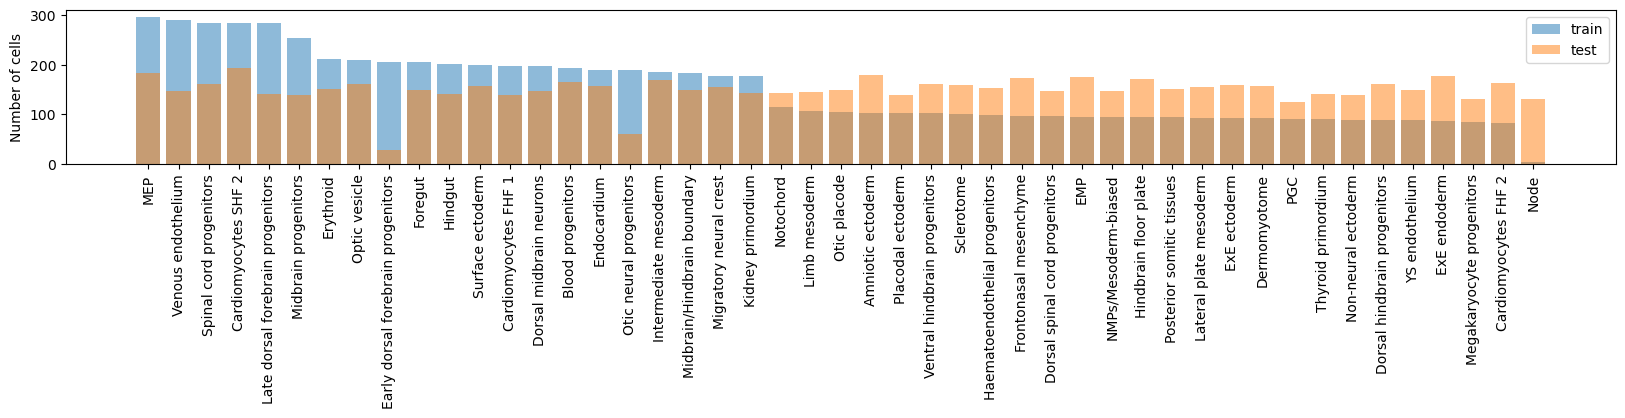

In [10]:
plt.figure(figsize=(20,2))
plt.bar(merged_label_counts.index, merged_label_counts['count_train'],alpha=0.5, label='train')
plt.bar(merged_label_counts.index, merged_label_counts['count_test'], alpha=0.5, label='test')
plt.ylabel("Number of cells")
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [11]:
annot = sc.queries.biomart_annotations('mmusculus', ['ensembl_gene_id', 'external_gene_name']).set_index('ensembl_gene_id')

In [12]:
adata_train.var[annot.columns] = annot

In [13]:
adata_train.var

,external_gene_name
ENSMUSG00000051951,Xkr4
ENSMUSG00000089699,Gm1992
ENSMUSG00000102343,Gm37381
ENSMUSG00000025900,Rp1
ENSMUSG00000025902,Sox17
...,...
ENSMUSG00000065947,mt-Nd4l
ENSMUSG00000064363,mt-Nd4
ENSMUSG00000064367,mt-Nd5
ENSMUSG00000064368,mt-Nd6


In [14]:
adata_train.var['mt'] = adata_train.var['external_gene_name'].str.startswith("mt-")
adata_train = adata_train[:, ~adata_train.var['mt'].isnull()]

In [15]:
train_expressions = adata_train.X.toarray()
print(np.sum(train_expressions==0))
print(train_expressions.size)

175224352
187943000


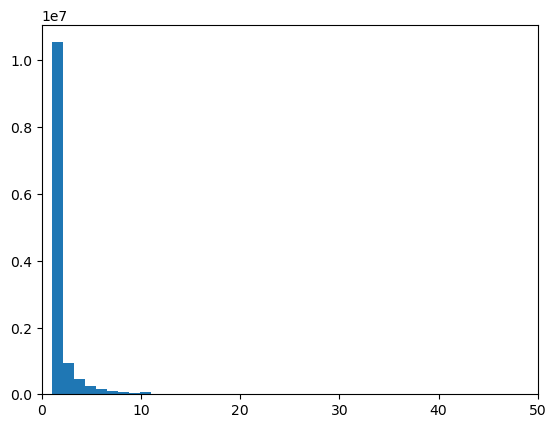

In [16]:
plt.hist(train_expressions[train_expressions!=0].flatten(), bins=1024)
plt.xlim(0,50)
plt.show()

In [17]:
adata_train.layers["counts"] = adata_train.X.copy()
adata_train.var_names = adata_train.var['external_gene_name']
adata_train.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata_train, qc_vars='mt', inplace=True, log1p=False)

/var/folders/yw/486n_std62vfzrxvh1t8_94m0000gn/T/ipykernel_1936/3642575388.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_train.layers["counts"] = adata_train.X.copy()


In [18]:
adata_train.var_names

Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Sox17', 'Gm37323', 'Mrpl15',
       'Lypla1', 'Gm37988', 'Tcea1',
       ...
       'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4',
       'mt-Nd5', 'mt-Nd6', 'mt-Cytb'],
      dtype='object', name='external_gene_name', length=26849)

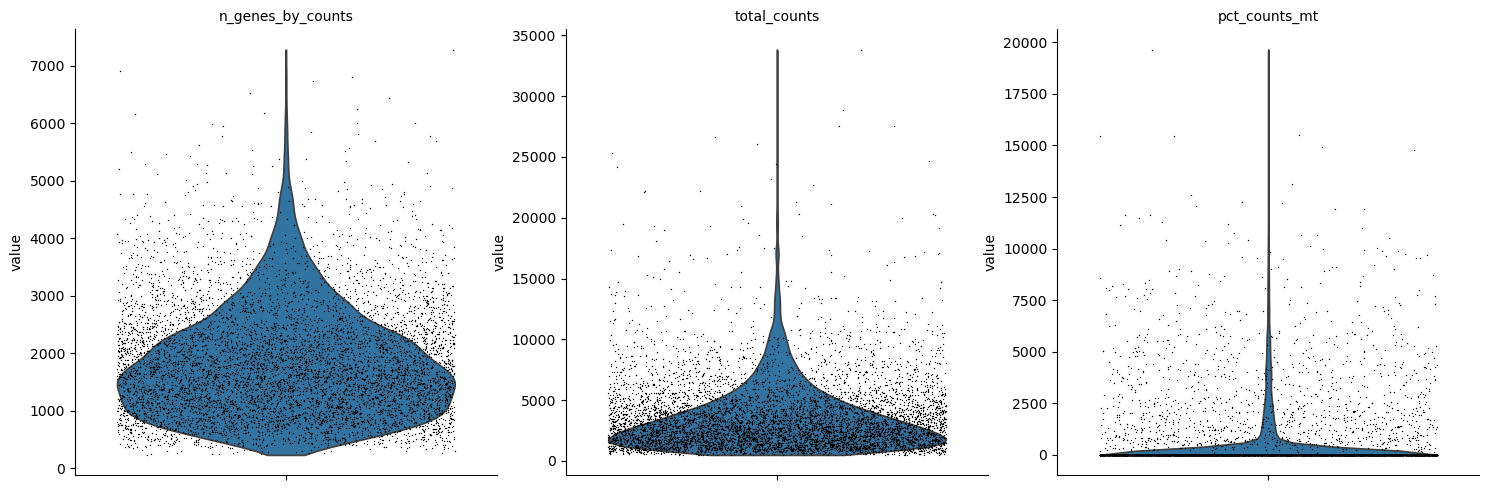

In [19]:
sc.pl.violin(
    adata_train,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [25]:
adata_train.X[:20,:20].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 3., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 2.],
       [7., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2.,
        1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 8., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.

In [ ]:
mt_genes = adata_train.var['mt']
mt_counts = adata_train.X[:, mt_genes].sum(axis=1)
total_counts = adata_train.X.sum(axis=1)
pct_counts_mt_manual = np.asarray(mt_counts / total_counts * 100).flatten()

print(pct_counts_mt_manual.min(), pct_counts_mt_manual.max())


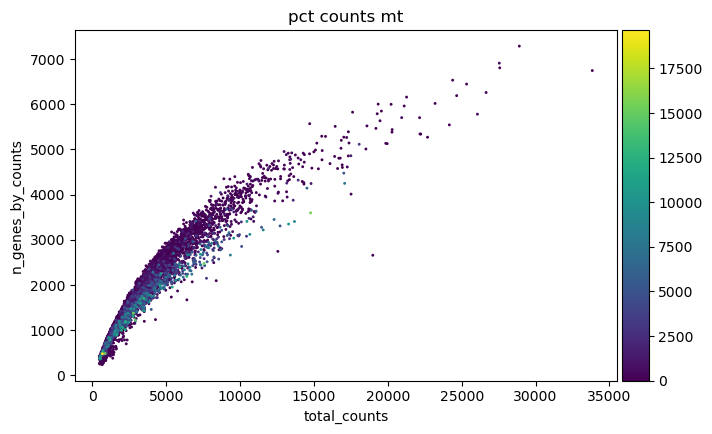

In [ ]:
sc.pl.scatter(adata_train, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
sc.pp.scrublet(adata_train)
sc.pp.normalize_total(adata_train)
sc.pp.log1p(adata_train)

In [ ]:
normalized_train_expressions = adata_train.X.toarray()
normalized_train_expressions[normalized_train_expressions==0].size

175224352

In [ ]:
normalized_train_expressions.size

187943000

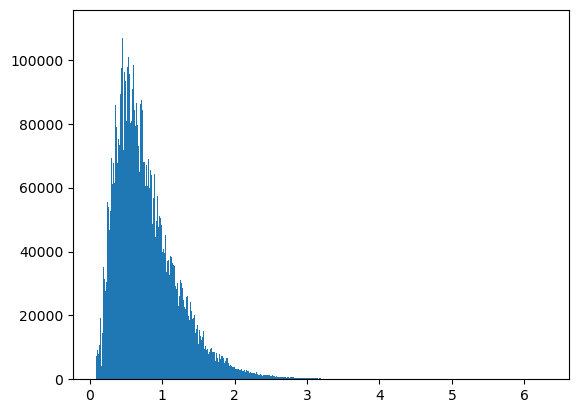

In [ ]:
plt.hist(normalized_train_expressions[normalized_train_expressions!=0].flatten(), bins=1024)
plt.show()

/var/folders/yw/486n_std62vfzrxvh1t8_94m0000gn/T/ipykernel_1852/1196727119.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


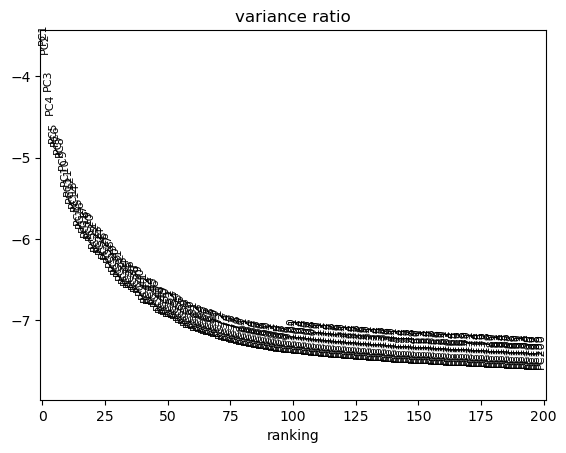

In [ ]:
n_comps = 200
sc.tl.pca(adata_train, n_comps=n_comps)
fig = sc.pl.pca_variance_ratio(adata_train, n_pcs=n_comps, log=True, show=False)
fig = plt.gcf()
plt.tight_layout()

In [ ]:
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)

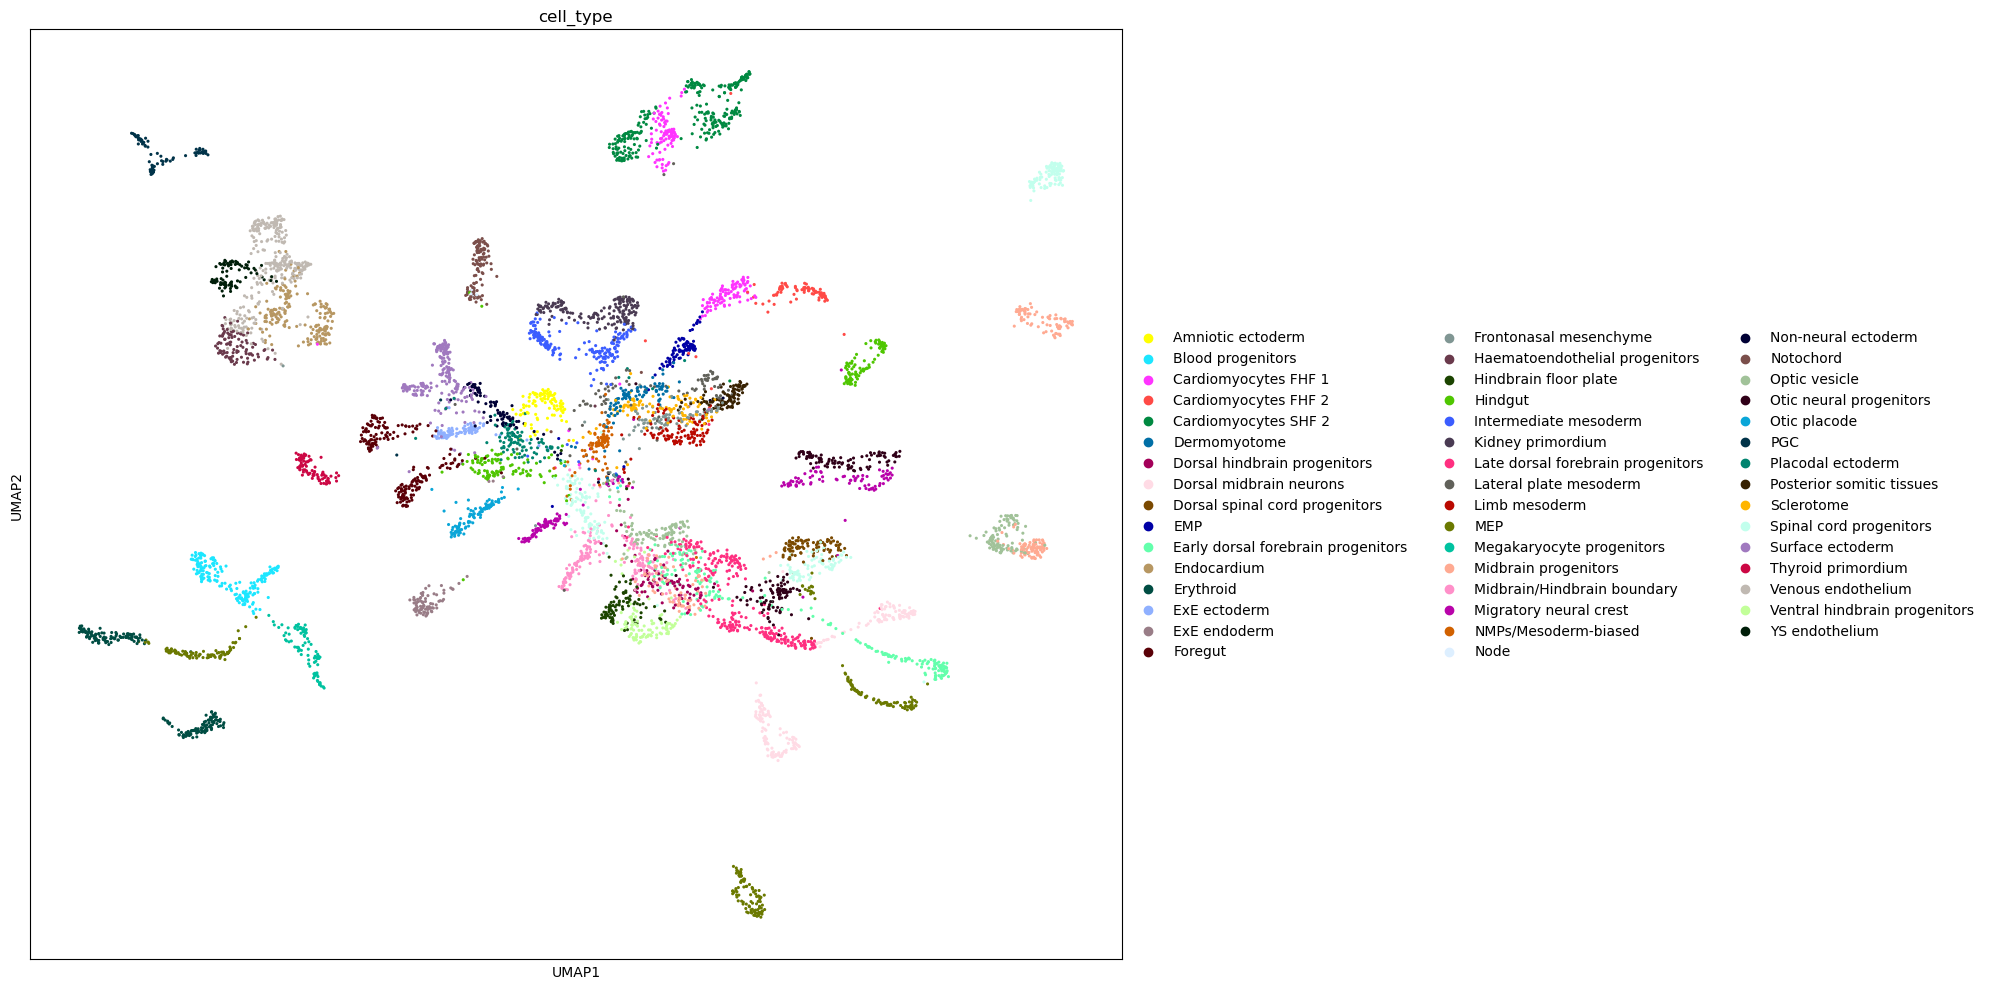

In [ ]:
fig = sc.pl.umap(
    adata_train,
    color="cell_type",
    size=20,
    show=False
)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(20)

plt.tight_layout()

/var/folders/yw/486n_std62vfzrxvh1t8_94m0000gn/T/ipykernel_1852/3420815362.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


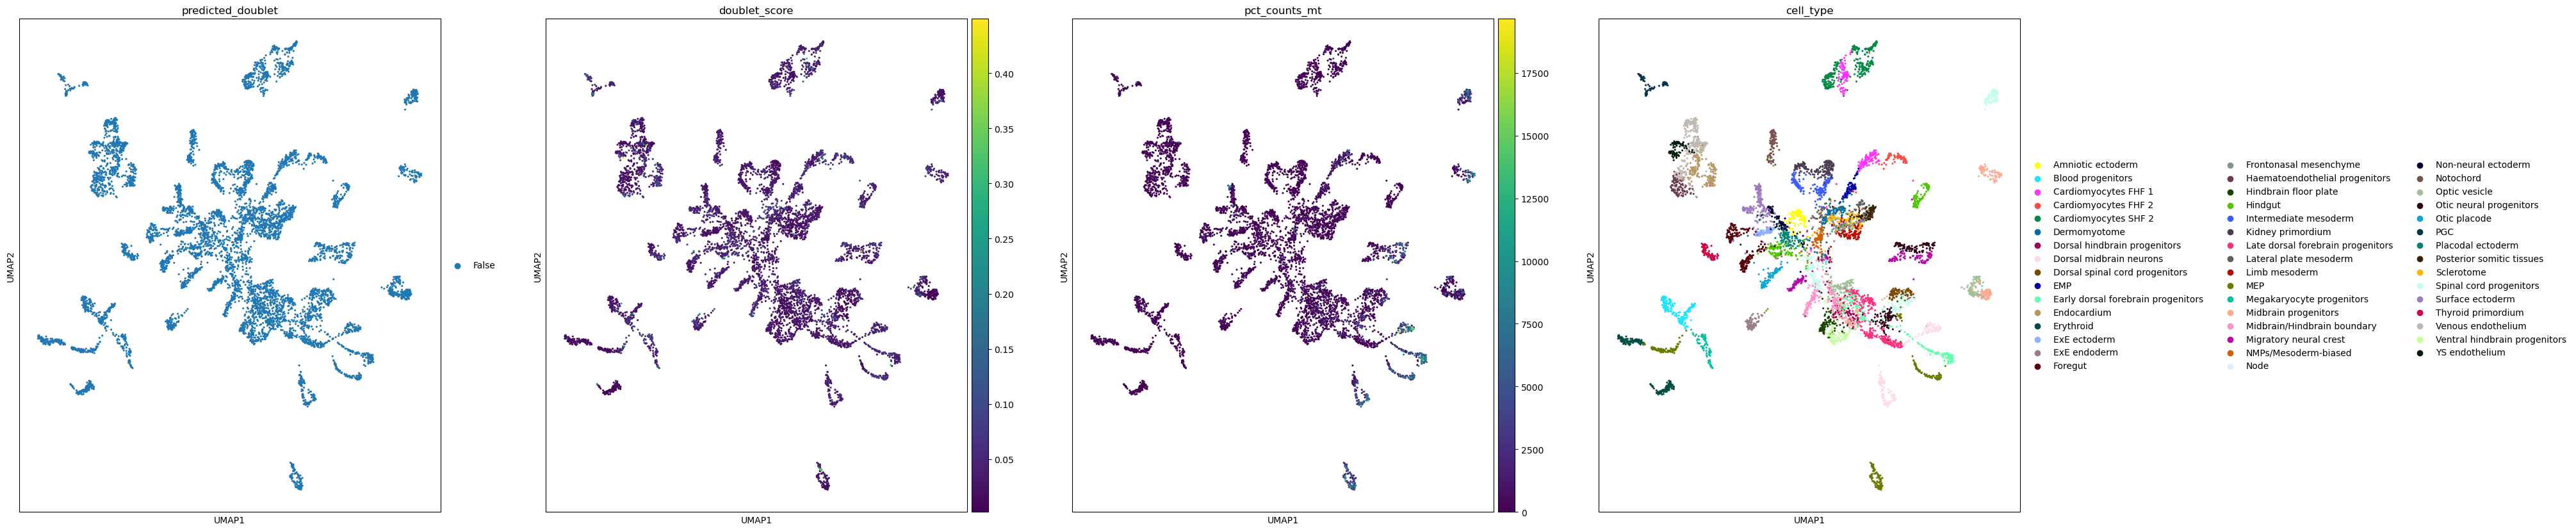

In [ ]:
fig = sc.pl.umap(
    adata_train,
    color=['predicted_doublet',
           'doublet_score',
           'pct_counts_mt',
           'cell_type'
           ],
    size=20,
    show=False
)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(40)

plt.tight_layout()

In [ ]:
adata_train.obs['predicted_doublet'].sum()

np.int64(0)

In [ ]:
adata_train.obs['pct_counts_mt']

run_4_PC-12D.ACTTCCGTTAGTAACGGTC-0            0.0
run_21_PB-02H_S112.TGCGTAGTTCGAGCTGCCA-10     0.0
run_14_PX-06G_S143.GCTTCTGGTTTCTTAATAA-2      0.0
run_16_PC-10C_S267.AAAGCTGATTTTACGATGAA-4     0.0
run_4_PE-02C.ACGCTTATATTGACGCTCCG-0           0.0
                                             ... 
run_25_PA-03D_S20.AAGTTCTTGTTTATAAGAAC-14     0.0
run_17_PD-09E_S357.AAGGATTACTAGGTTAGTTC-5     0.0
run_19_PC-09G_S263.AGGCTCGTTCGGTTATGCC-8      0.0
run_20_PB-04H_S128.GGTACGGATCCAACTAACC-9      0.0
run_25_PD-06E_S333.ACTTGATTGTTCAGCTCTAA-14    0.0
Name: pct_counts_mt, Length: 7000, dtype: float32

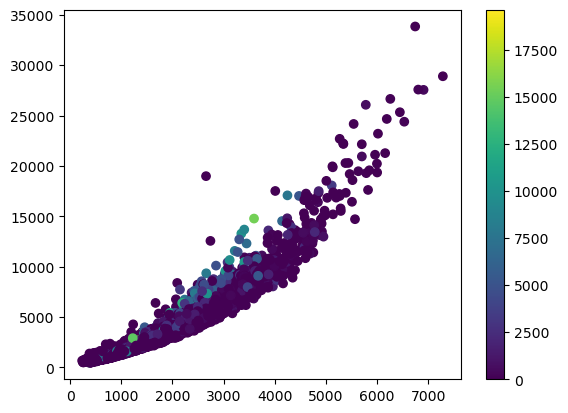

In [ ]:
plt.scatter(adata_train.obs['n_genes_by_counts'], adata_train.obs['total_counts'], c=adata_train.obs['pct_counts_mt'])
plt.colorbar()

(array([6.318e+03, 3.270e+02, 2.000e+02, 7.500e+01, 4.500e+01, 2.200e+01,
        7.000e+00, 5.000e+00, 0.000e+00, 1.000e+00]),
 array([    0.        ,  1964.56799316,  3929.13598633,  5893.70410156,
         7858.27197266,  9822.83984375, 11787.40820312, 13751.97558594,
        15716.54394531, 17681.11132812, 19645.6796875 ]),
 <BarContainer object of 10 artists>)

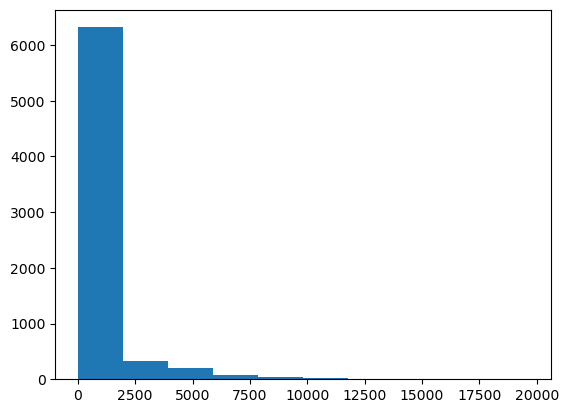

In [ ]:
plt.hist(adata_train.obs['pct_counts_mt'])

(array([6.809e+03, 1.400e+02, 3.400e+01, 7.000e+00, 6.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([      0.,  228106.,  456212.,  684318.,  912424., 1140530.,
        1368636., 1596742., 1824848., 2052954., 2281060.]),
 <BarContainer object of 10 artists>)

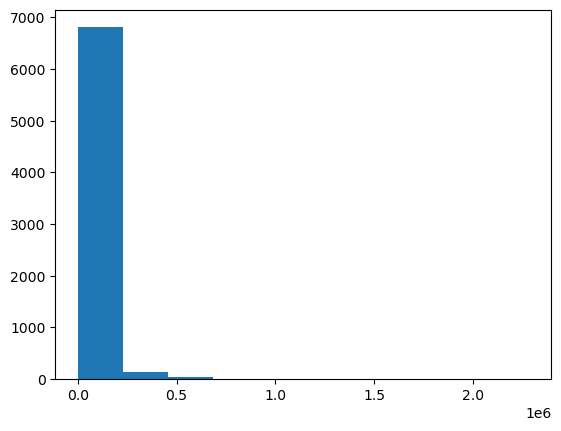

In [ ]:
plt.hist(adata_train.obs['total_counts_mt'])